In [1]:
from pathlib import Path
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import shapefile
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon as pltPolygon
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon


class TreeGrid2D:
    def __init__(self, shape_file_name: str):

        self.file_name = shape_file_name

        self.raw_polygon_data = self._extract_polygon_data()

        self.polygon_list = self._extract_polygon()

    def _extract_polygon_data(self) -> List[List[Tuple]]:
        """The only one time open this shapefile.

        Read and store the list of polygon in "raw_polygon_data"

        Return: 
            list of polygon, where each polygon is a list of tuple,(x:float,y:float)
        """
        polygon_data = []
        print(self.file_name)
        with shapefile.Reader(self.file_name) as shp:

            for s in shp.shapeRecords():
                polygon = s.shape.points
                polygon_data.append(polygon)

        return polygon_data

    def _extract_polygon(self) -> List[Polygon]:
        """
        Use the data from 'raw_polygon_data' to constuct
            a list of shapely.geometry.polygon.Polygon object.
            Which is useful to check in a point is contain inside 
            a given polygon.

        Return:
            list of "shapely.geometry.polygon.Polygon" objects.
        """
        polygon_list = []

        for polygon_data in self.raw_polygon_data:
            polygon_list.append(Polygon(polygon_data))

        return polygon_list

    def plot(self, distance_from_center: int = 40,
             fig_size: tuple = (10, 10)) -> None:
        """
        Ploting the polygons
        """
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xlim([-distance_from_center, distance_from_center])
        ax.set_ylim([-distance_from_center, distance_from_center])
        patches = []

        for i in range(len(self.raw_polygon_data)):
            #     polygon = pltPolygon(np.random.rand(num_sides ,2), True)
            polygon = pltPolygon(np.array(self.raw_polygon_data[i]), True)
            patches.append(polygon)

        p = PatchCollection(patches, cmap=plt.cm.jet, alpha=0.4)

        # colors = 100*np.random.rand(len(patches))
        # p.set_array(np.array(colors))

        ax.add_collection(p)

        plt.show()


In [2]:
from typing import List, Tuple

import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon



def mapping_from_point_to_cell(x_axis_used: List[float], y_axis_used: List[float], x: float, y: float) -> Tuple[int, int]:

    try:
        x_cell_axis = x_axis_used.tolist().index(x)
    except:
        x_cell_axis = int(x_axis_used[np.abs(x_axis_used - x).argmin()])
    try:
        y_cell_axis = y_axis_used.tolist().index(y)
    except:
        y_cell_axis = int(y_axis_used[np.abs(y_axis_used - y).argmin()])

    return (x_cell_axis, y_cell_axis)


def make_polygon(minx, miny, maxx, maxy) -> Polygon:

    return Polygon([[minx, miny], [minx, maxy], [maxx, maxy], [maxx, miny]])


def _generate_x_y_axis_sequence(minx: float, maxx: float,
                                miny: float, maxy: float, width: float) -> Tuple:
    """
    Return
        Tuple of np.array
    """

    minx = np.floor(minx)
    miny = np.floor(miny)
    maxx = np.ceil(maxx)
    maxy = np.ceil(maxy)

    x_axis = np.arange(minx, maxx + width, width)

    y_axis = np.arange(miny, maxy + width, width)

    return (x_axis, y_axis)




def generate_list_of_blocked_points(polygon: Polygon, x_axis_used: np.array,
                                    y_axis_used: np.array,
                                    width: float) -> List[Point]:
    """Given a polygon and the axises definded the coordinate, compute a list of blocked points.

    Args:
        polygon (Polygon): [description]
        x_axis_used (np.array): [description]
        y_axis_used (np.array): [description]
        width (float): [description]

    Returns:
        List[Point]: [description]
    """
    # Adjust the value for bounds.
    minx, miny, maxx, maxy = polygon.bounds
    # Find the cloest point in the axis
    minx = x_axis_used[np.abs(x_axis_used - minx).argmin()]
    maxx = x_axis_used[np.abs(x_axis_used - maxx).argmin()]
    miny = y_axis_used[np.abs(y_axis_used - miny).argmin()]
    maxy = y_axis_used[np.abs(y_axis_used - maxy).argmin()]

    x_axis = [i for i in x_axis_used if (i >= minx) and (i <= maxx)]
    y_axis = [i for i in y_axis_used if (i >= miny) and (i <= maxy)]

    # All combinations of x_axis and y_axis values
    point_grid = np.array(np.meshgrid(x_axis, y_axis)).T.reshape(-1, 2)

    assert (point_grid.shape[0] == len(x_axis) * len(y_axis))

    points_in_square = [Point(d) for d in point_grid]

    points_in_polygon = [p for p in points_in_square if polygon.contains(p)]

    return points_in_polygon


def matrixrize_polygon(minx: float, miny: float, maxx: float, maxy: float,
                       tree_grid: TreeGrid2D, width: float) -> List[List[int]]:
    """Generate a list of lists, where the innerlist indicates wheather or not a given cell
    as blocked.

    Args:
        minx (float): left-most bound
        miny (float): button-most bound
        maxx (float): right-most bound
        maxy (float): top-most bound
        tree_grid (TreeGrid2D): Contains a list of Polygon objects
        width (float): To set the desirable density of the grid

    Returns:
        List[List[int]]: [description]
    """

    # Generate sequences for constuction of the grid.
    x_axis, y_axis = _generate_x_y_axis_sequence(minx, maxx, miny, maxy, width)

    # Step up a empty grid.
    matrix_cells = [[0 for i in range(len(x_axis))]
                    for j in range(len(y_axis))]

    for p in tree_grid.polygon_list:
        
        # Generate all points inside the given polygon
        blocked_points = generate_list_of_blocked_points(p, x_axis_used=x_axis,
                                                         y_axis_used=y_axis, width=width)

        K, J = len(x_axis) - 1, len(y_axis) - 1
        # print("J : {}".format(J))
        # M = np.array(matrix_cells)
        # print("M : {}".format(M.shape))

        for p in blocked_points:

            x, y = mapping_from_point_to_cell(x_axis, y_axis, p.x, p.y)
            # print("x : {} , y : {}".format(x, y))
            if y > 0:
                matrix_cells[J - y][x] = 1
    return matrix_cells


In [12]:
g = TreeGrid2D('../test_hulls.shp')

../test_hulls.shp


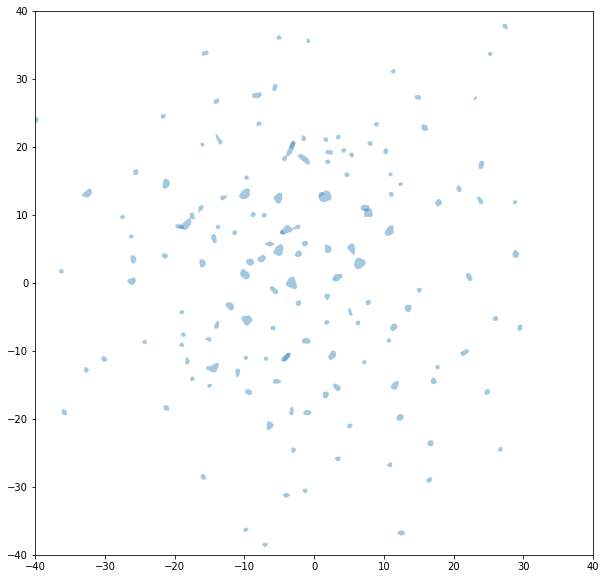

In [13]:
g.plot()

In [71]:
distance = 10
width = 0.2

minx = -distance
miny = -distance
maxx = distance
maxy = distance

cells = matrixrize_polygon(minx, miny, maxx, maxy, g, width)

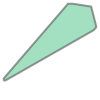

In [72]:
g.polygon_list[0]

In [73]:
pp = pprint.PrettyPrinter(width=len(cells[0]) * 6, compact=True)
pp.pprint(cells)

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,

In [6]:
!ls ..

myscript.py            test_concave_hulls.dbf test_hulls.dbf
polygon_tools          test_concave_hulls.shp test_hulls.shp
shape                  test_concave_hulls.shx test_hulls.shx
